In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import pickle

from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,LabelEncoder,MaxAbsScaler,RobustScaler

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder,LabelEncoder,MaxAbsScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from keras.models import Sequential
from numpy import loadtxt
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import phik
from sklearn.metrics import cohen_kappa_score

import warnings
warnings.filterwarnings('ignore')


RANDOM_STATE = 42

### Definition of Functions

In [2]:
def metrics(y_train, pred_train , y_val, pred_val):
    """
    Function that pritns the classification report and the confusion matrix of the train and validation dataset
    """
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                    TESTING                                                ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [3]:
def micro_f1_score(y_train, pred_train , y_val, pred_val):
    """
    Function that pritns the micro f1 score of the train and validation dataset
    """
    print('_____________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(f1_score(y_train, pred_train, average='micro'))

    print('_____________________________________')
    print('                                                    TESTING                                                ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(f1_score(y_val, pred_val, average='micro'))
    return f1_score(y_val, pred_val, average='micro')

In [4]:
def best_scale(model,X_train,y_train,X_test,y_test):
    """
    Function that returns a table with the micro f1 score for the different scaler
    """
    standard=StandardScaler().fit(X_train).transform(X_train)
    standardTest=StandardScaler().fit(X_test).transform(X_test)

    minMax=MinMaxScaler().fit(X_train).transform(X_train)
    minMaxTest=MinMaxScaler().fit(X_test).transform(X_test)

    maxAbs=MaxAbsScaler().fit(X_train).transform(X_train)
    maxAbsTest=MaxAbsScaler().fit(X_test).transform(X_test)
        
    robust=RobustScaler().fit(X_train).transform(X_train)
    robustTest=RobustScaler().fit(X_test).transform(X_test)

    sclares=[standard,minMax,maxAbs,robust,X_train]
    sclaresTest=[standardTest,minMaxTest,maxAbsTest,robustTest,X_test]
    
    f_score=[]
    
    for i in range(len(sclares)):
        model.fit(sclares[i],y_train)
        y_pred=model.predict(sclaresTest[i])
        f_score.append(f1_score(y_pred,y_test,average="micro"))
        

    return pd.DataFrame(f_score,index=["Standard","MinMax","MaxAbs","Robust","No Scaler"], columns=["F1 Score"])
    

In [5]:
def bar_charts_categorical(df, feature, target):
    """
    Function that plots the frequency and the importance that a categorical variable has with the target
    """
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="lightblue")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="orange")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.xticks(rotation="vertical")
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="lightblue")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="orange")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'),labelspacing =1)
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.xticks(rotation="vertical")
    plt.show()

### Importing Data

#### Describe, explore and assess the data

In [6]:
#To import data from a .csv file to a pandas dataframe
df = pd.read_csv("H2.csv")
df

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,...,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,...,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,...,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,...,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [7]:
#To return a tuple representing the dimensionality of the DataFrame
df.shape

(79330, 31)

In [8]:
#To return the dtypes in the DataFrame
#In this way, we can start looking better at our data
df.dtypes

IsCanceled                       int64
LeadTime                         int64
ArrivalDateYear                  int64
ArrivalDateMonth                object
ArrivalDateWeekNumber            int64
ArrivalDateDayOfMonth            int64
StaysInWeekendNights             int64
StaysInWeekNights                int64
Adults                           int64
Children                       float64
Babies                           int64
Meal                            object
Country                         object
MarketSegment                   object
DistributionChannel             object
IsRepeatedGuest                  int64
PreviousCancellations            int64
PreviousBookingsNotCanceled      int64
ReservedRoomType                object
AssignedRoomType                object
BookingChanges                   int64
DepositType                     object
Agent                           object
Company                         object
DaysInWaitingList                int64
CustomerType             

In [9]:
# Summary statistics for all variables
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IsCanceled,79330,NaN,NaN,NaN,0.41727,0.493111,0,0,0,1,1
LeadTime,79330,NaN,NaN,NaN,109.736,110.949,0,23,74,163,629
ArrivalDateYear,79330,NaN,NaN,NaN,2016.17,0.699181,2015,2016,2016,2017,2017
ArrivalDateMonth,79330,12,August,8983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrivalDateWeekNumber,79330,NaN,NaN,NaN,27.1774,13.3985,1,17,27,38,53
ArrivalDateDayOfMonth,79330,NaN,NaN,NaN,15.7866,8.72845,1,8,16,23,31
StaysInWeekendNights,79330,NaN,NaN,NaN,0.795185,0.885026,0,0,1,2,16
StaysInWeekNights,79330,NaN,NaN,NaN,2.18296,1.45642,0,1,2,3,41
Adults,79330,NaN,NaN,NaN,1.85098,0.509292,0,2,2,2,4
Children,79326,NaN,NaN,NaN,0.0913698,0.372177,0,0,0,0,3


In [10]:
#Exploring the data, we could notice that some variables had a lot of useless spaces in their names
#We decide to remove their spaces 
features = ['Meal', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'Company']

for feature in features:
    df[feature] = df[feature].str.strip()

### Data Exploration  


In [11]:
#Checking for missing data
df.isnull().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
Agent                           0
Company                         0
DaysInWaitingList               0
CustomerType                    0
ADR                             0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationSta

In [12]:
#To see how many nan values that we have in 'Children' column
perc_nan_child = (df['Children'].isnull().sum())/(len(df['Children'])) * 100
perc_nan_child

0.005042228665069961

In [13]:
#As we can see we, we have a very low percentage, less than 3%, so we can remove all this values
df = df[pd.notnull(df['Children'])]

In [14]:
#To verify if the nan values in 'Children' column are eliminated
df.isnull().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        0
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
Agent                           0
Company                         0
DaysInWaitingList               0
CustomerType                    0
ADR                             0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationSta

In [15]:
#To see how many nan values that we have in 'Country' column
perc_nan_country = (df['Country'].isnull().sum())/len(df['Country'])*100
perc_nan_country

0.03025489751153468

In [16]:
#As we can see, we don't have either a lot of have nan values in the 'Country' column.
#However, we decided to fill these values with 'Nan' with 'Unknown' because they do not know the customer's nationality.
#However, we didn't use this feature for predictive models
df['Country'].fillna("Unknown", inplace=True)

In [17]:
#To check if we still have nan values
df.isnull().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
Agent                          0
Company                        0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
Reservatio

In [18]:
#As we can see before, there are 2 variables that we can change the type 
df.dtypes

IsCanceled                       int64
LeadTime                         int64
ArrivalDateYear                  int64
ArrivalDateMonth                object
ArrivalDateWeekNumber            int64
ArrivalDateDayOfMonth            int64
StaysInWeekendNights             int64
StaysInWeekNights                int64
Adults                           int64
Children                       float64
Babies                           int64
Meal                            object
Country                         object
MarketSegment                   object
DistributionChannel             object
IsRepeatedGuest                  int64
PreviousCancellations            int64
PreviousBookingsNotCanceled      int64
ReservedRoomType                object
AssignedRoomType                object
BookingChanges                   int64
DepositType                     object
Agent                           object
Company                         object
DaysInWaitingList                int64
CustomerType             

In [19]:
#To change from float to int the 'Children' type
#To change from object to data the 'Children' type
df['Children'] = df['Children'].astype(int)
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])

In [20]:
#To verify the changes made
df.dtypes

IsCanceled                              int64
LeadTime                                int64
ArrivalDateYear                         int64
ArrivalDateMonth                       object
ArrivalDateWeekNumber                   int64
ArrivalDateDayOfMonth                   int64
StaysInWeekendNights                    int64
StaysInWeekNights                       int64
Adults                                  int64
Children                                int64
Babies                                  int64
Meal                                   object
Country                                object
MarketSegment                          object
DistributionChannel                    object
IsRepeatedGuest                         int64
PreviousCancellations                   int64
PreviousBookingsNotCanceled             int64
ReservedRoomType                       object
AssignedRoomType                       object
BookingChanges                          int64
DepositType                       

In [21]:
#To return boolean Series denoting duplicate rows
#As we can see, we have some duplicates, however we decided to include it to the models
df.loc[df.duplicated(keep=False), :]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
8,1,62,2015,July,27,2,2,3,2,0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
9,1,62,2015,July,27,2,2,3,2,0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
10,0,43,2015,July,27,3,0,2,2,0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
12,0,43,2015,July,27,3,0,2,2,0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
17,0,43,2015,July,27,3,0,2,2,0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79292,0,63,2017,August,35,31,0,3,3,0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79293,0,63,2017,August,35,31,0,3,3,0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79294,0,63,2017,August,35,31,0,3,3,0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79312,0,175,2017,August,35,31,1,3,1,0,...,No Deposit,42,NULL,0,Transient,82.35,0,1,Check-Out,2017-09-04


### Data Preparation

In [54]:
#To separate the non_metric_features from metric_features
non_metric_features = df.select_dtypes(include="object").columns.to_list()
metric_features = df.columns.drop(non_metric_features).to_list()

In [55]:
#To remove the target value, the 'IsRepeatedGuest' and the 'ReservationStatusDate' from the metric_feature list
metric_features.remove('IsRepeatedGuest')
metric_features.remove('IsCanceled')
metric_features.remove('ReservationStatusDate')

In [56]:
#To divide the variables that are in the metric_features to do the boxplots
metric_features_1 = metric_features[0:8]
metric_features_2 = metric_features[8:]

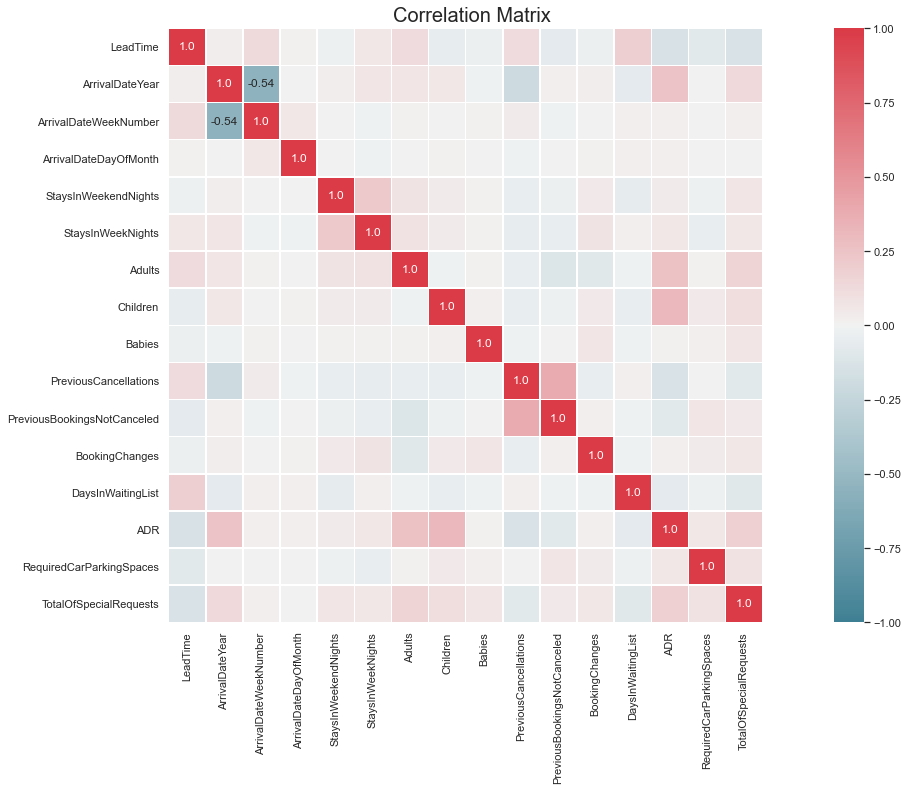

In [57]:
#To see the correlation between the matric variables
# Prepare figure
fig = plt.figure(figsize=(20, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95, left = -0.09)
fig.suptitle("Correlation Matrix", fontsize= 20)

plt.show()

In [58]:
#pip install phik==0.10.0

In [59]:
matrix = df.phik_matrix()

interval columns not set, guessing: ['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests']


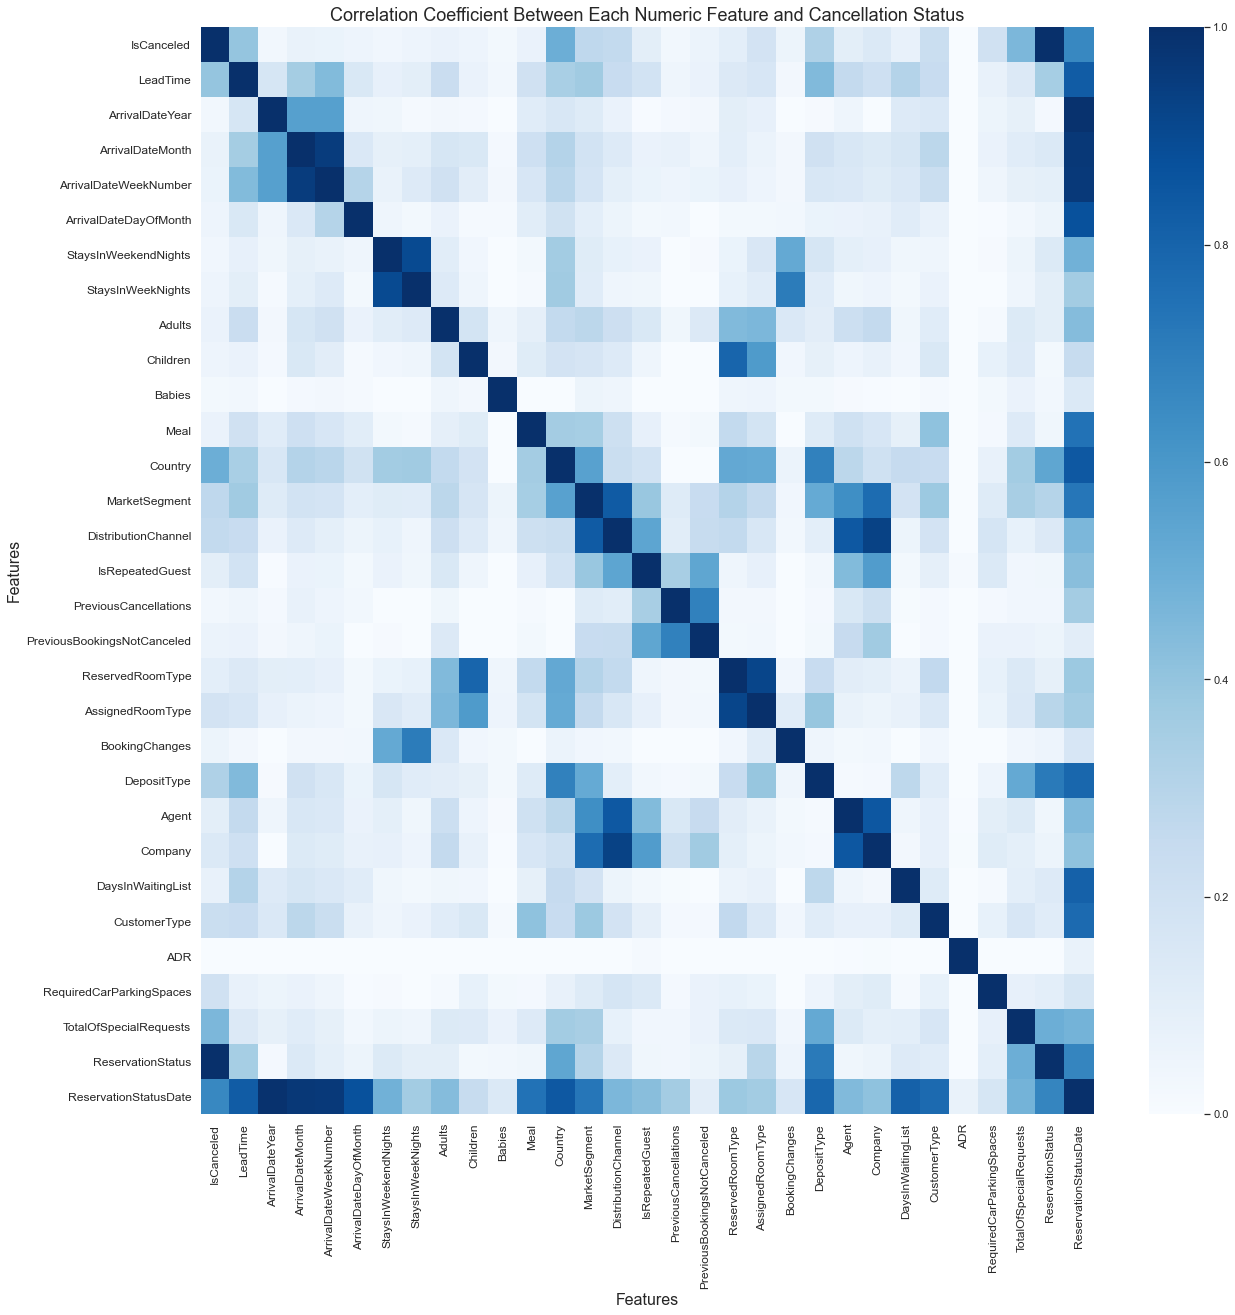

In [60]:
# To visualize the correlation coefficients between features and cancellation:
fig = plt.figure(figsize=(20,20))

ax = sns.heatmap(matrix, annot = False, annot_kws = {"size":12}, cmap='Blues')

ax.set_title('Correlation Coefficient Between Each Numeric Feature and Cancellation Status', fontsize=18)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12)

y_min, y_max = ax.get_ylim()

As we can see in the phik matrix, there are very highly correlated features in the phik matrix. For instance, 'ArrivalDateYear' and 'ReservationStatusDate' has 99% of correlation. There are another ones.

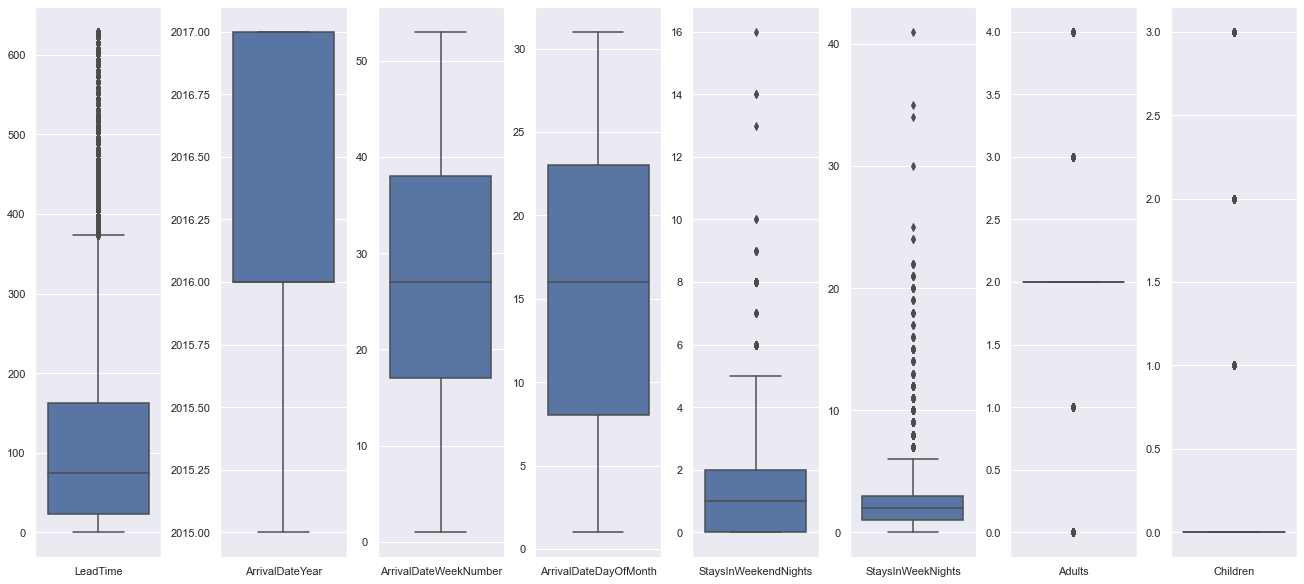

In [61]:
#To do the boxplots
sns.set()

plot_features_1 = df[metric_features_1].columns
fig, axes = plt.subplots(1, len(plot_features_1), figsize=(18,8), constrained_layout=True)

j=0
k=1

for i in zip(axes, plot_features_1):
    sns.boxplot(data=df[metric_features_1].iloc[:,j:k], ax=i[0])
    
    j=j+1
    k=k+1
    
plt.show()

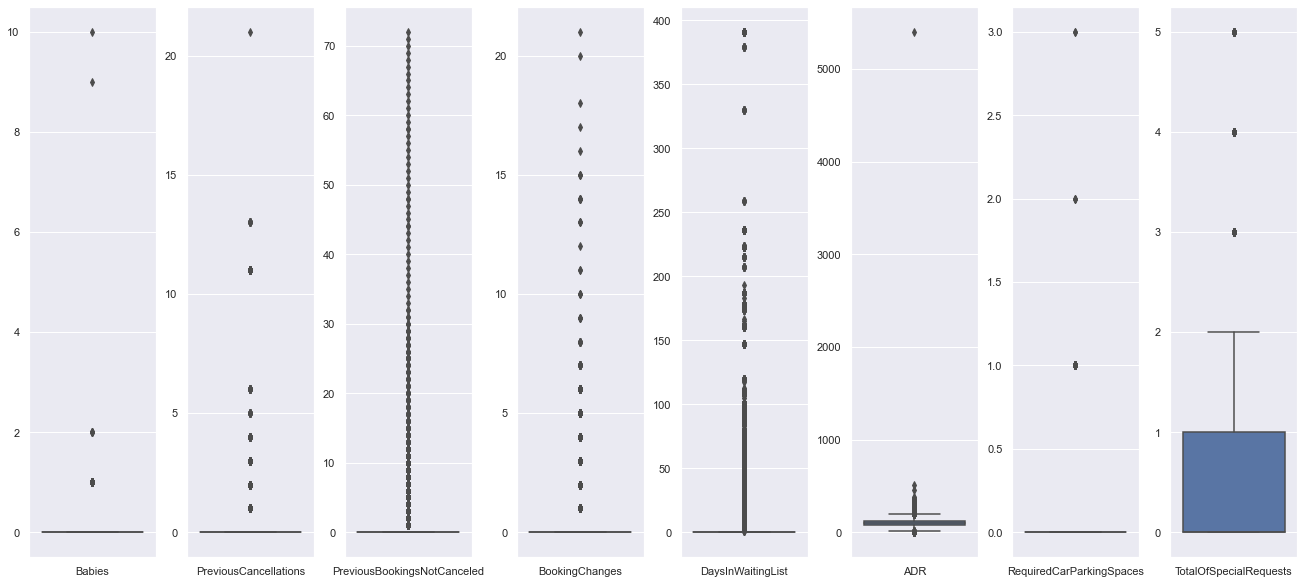

In [62]:
sns.set()

plot_features_2 = df[metric_features_2].columns
fig, axes = plt.subplots(1, len(plot_features_2), figsize=(18,8), constrained_layout=True)

j=0
k=1

for i in zip(axes, plot_features_2):
    sns.boxplot(data=df[metric_features_2].iloc[:,j:k], ax=i[0])
    
    j=j+1
    k=k+1
    
plt.show()

In [63]:
df.shape

(79326, 31)

In [64]:
#As we can see, we have some variables with outliers 
#So we are going to apply the IQR

def outlier(data_column):
    df1 = df[data_column]

    q1 = df1.quantile(0.25)
    q3 = df1.quantile(0.75)

    iqr = q3 - q1

    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)
    
    return lower_bound, upper_bound


In [65]:
#Here, we are going to see how many outliers exists
total_outliers = 0

for metric in metric_features:
    lower_bound, upper_bound = outlier(metric)
    out = len(df[(df[metric] < lower_bound) | (df[metric] > upper_bound)])
    total_outliers += out
    

In [66]:
#As we can see, there are a lot of outliers
#On other hand, they are not errors, and this way it will not helping prediction by removing them. Our predictive power will be more accurate than if we exclude them. So, we are going to do our models, our predicition without removing outliers
total_data_outliers = total_outliers/len(df) * 100
total_data_outliers 

72.78571968837456

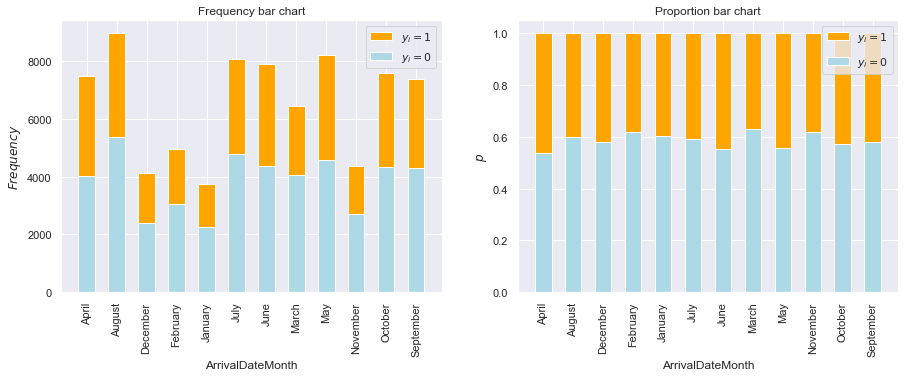

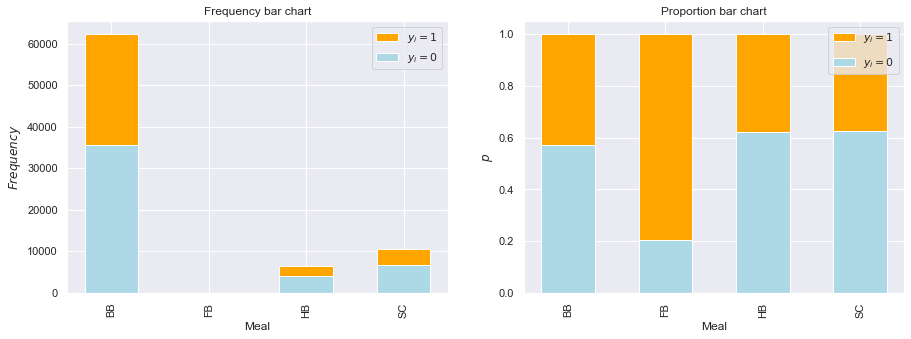

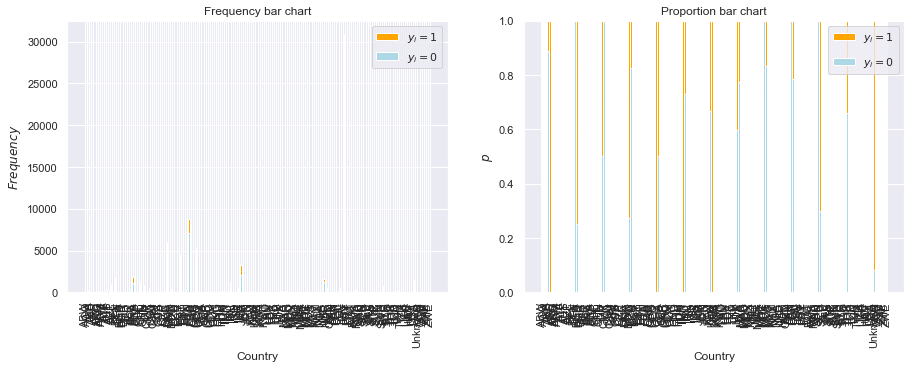

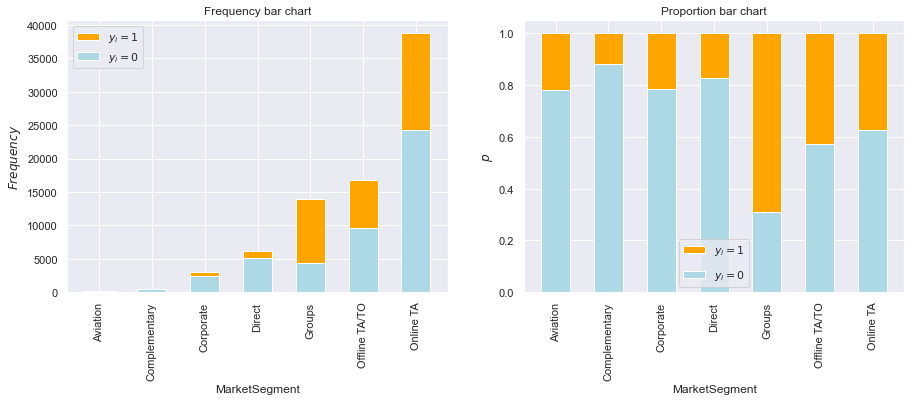

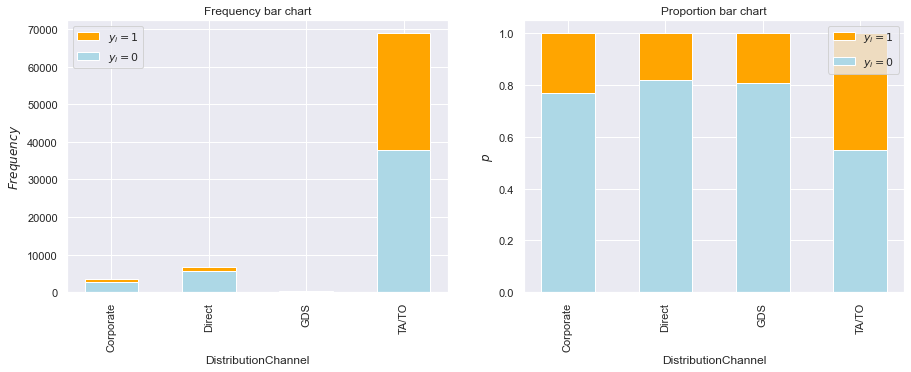

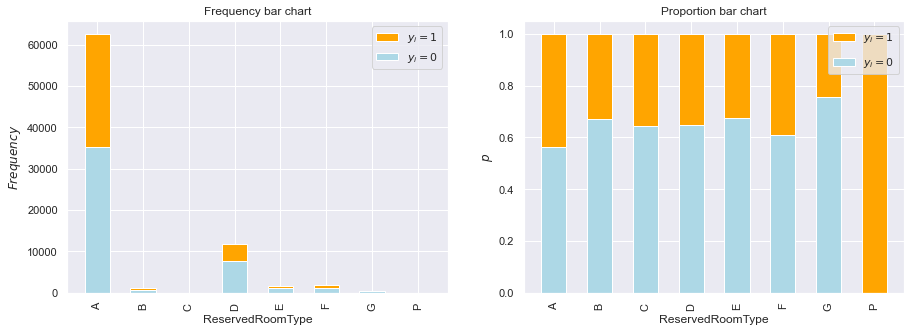

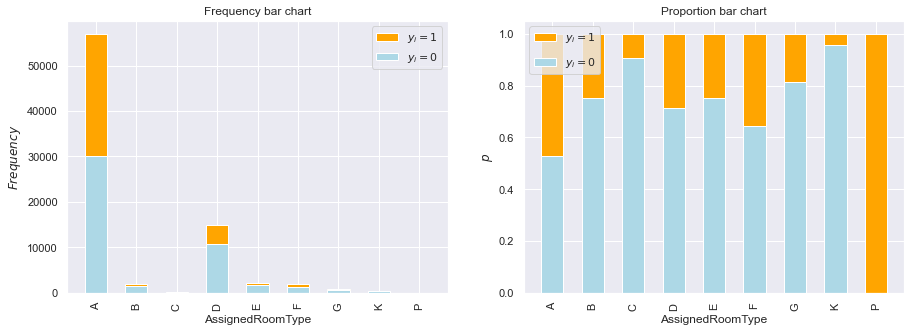

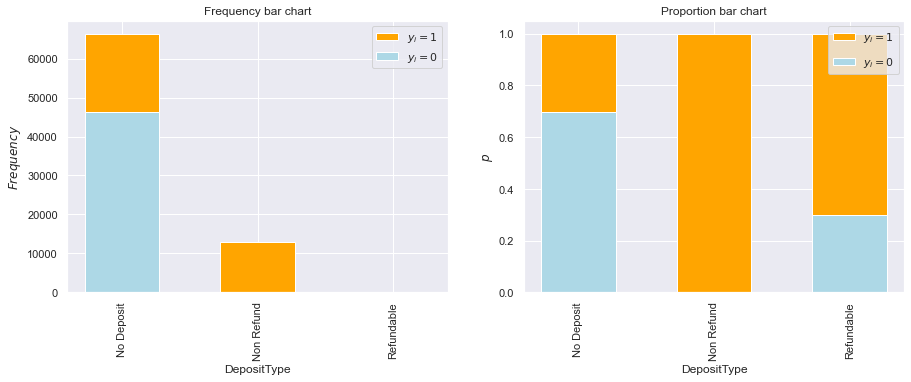

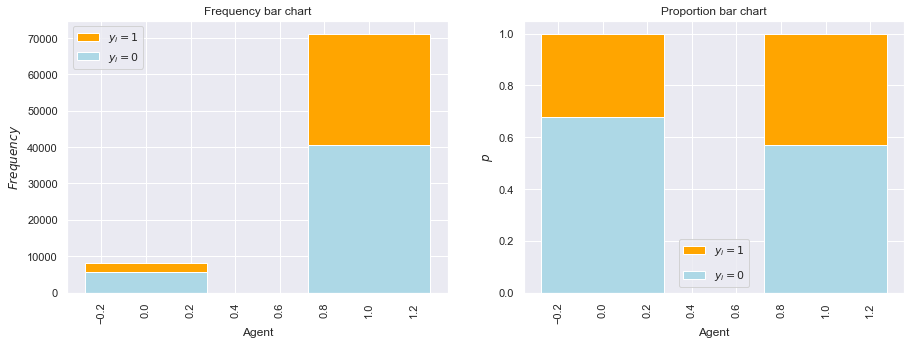

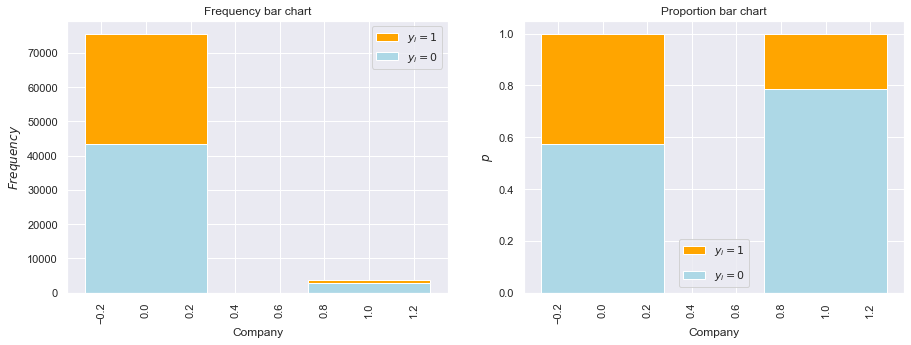

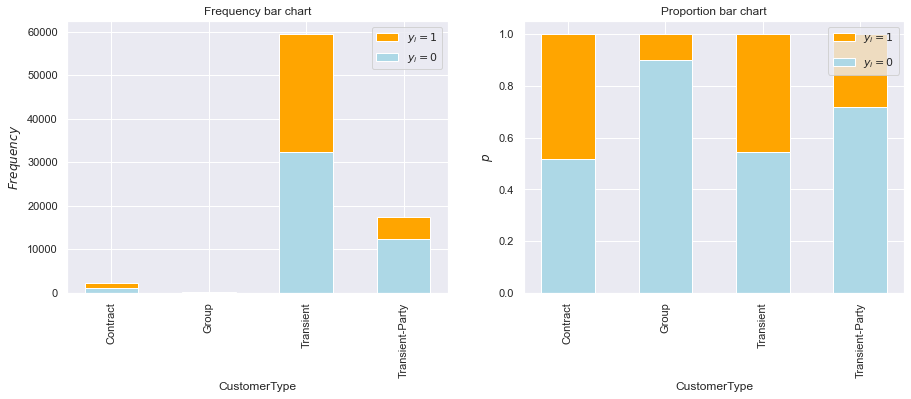

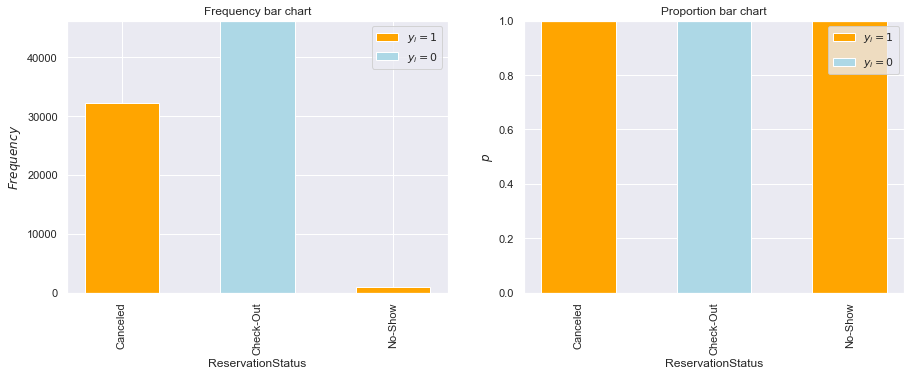

In [67]:
#To show the non_metric_features in a bar chart
for i in non_metric_features:   
    bar_charts_categorical(df, i, "IsCanceled")

#### Feature Engineering


In [68]:
#To convert the 'Agent' and 'Company' column to a categorical feature
df['Agent'] = df['Agent'].map(lambda x: 0 if x == 'NULL' else 1).astype(object)
df['Company'] = df['Company'].map(lambda x: 0 if x == 'NULL' else 1).astype(object)

The original dataset provides a custumer's arrival date with day, month, and year each in a separate feature. For analysis purposes, it is easier to have all of those elements combined into one arrival_date_full feature.

In [69]:
#As we can see our dataset provides the customer's arrival date with day, month and year each one separate. 
#So, we decided create a new variable with date type. This variable is the junction of the 3 talked above

In [70]:
# New feature for the arrival date in full: 
df['ArrivalDateFull'] = df['ArrivalDateYear'].astype(str) + "-" + df['ArrivalDateMonth'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + df['ArrivalDateDayOfMonth'].astype(str)
df['ArrivalDateFull'] = pd.to_datetime(df['ArrivalDateFull'], format="%Y-%m-%d")

In [71]:
# New feature for the length of the stay / Number of days before arrival for the customer to cancel:
df['StatusToArrivalDate'] = np.abs(df['ArrivalDateFull'] - df['ReservationStatusDate']).astype(str)

In [72]:
# formating the feature 
def format_lenght(date):
    return date[0]
df['StatusToArrivalDate'] = df['StatusToArrivalDate'].map(format_lenght).astype(int)

In [73]:
matrix = df.phik_matrix()

interval columns not set, guessing: ['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', 'StatusToArrivalDate']


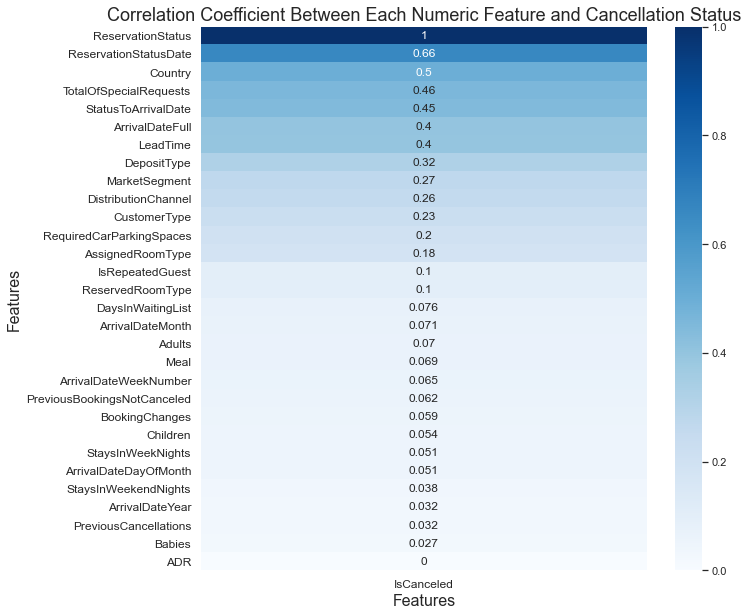

In [74]:
# To visualize correlation coefficients between features and cancellation:
fig = plt.figure(figsize=(10,10))

ax = sns.heatmap(matrix[['IsCanceled']].sort_values('IsCanceled', ascending=False), annot = True, annot_kws = {"size":12}, cmap='Blues')

ax.set_title('Correlation Coefficient Between Each Numeric Feature and Cancellation Status', fontsize=18)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12);

y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1);

As we can see, 'ReservationStatus' is the most highly correlated featured with 'IsCanceled'.

In [87]:
#To center the plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [88]:
#Now we are going to do some plots with diferent variables that can be correlated to the booking status

In [89]:
#First of all, we are going to show the percentage of canceled and not canceleded bookings

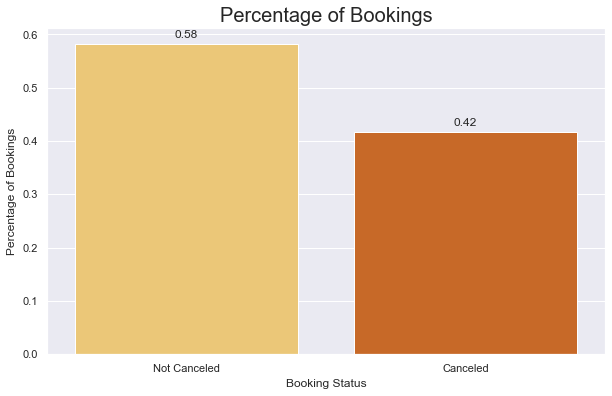

In [90]:
# To visualize the percentage of canceled and not canceled bookings
plt.figure(figsize=(10,6)) 
plt.title("Percentage of Bookings", fontsize = 20)

splot = sns.barplot(x=df['IsCanceled'].unique(), y=df['IsCanceled'].value_counts(normalize=True), palette='YlOrBr')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings", fontsize = 12, labelpad = 5)

plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

As we can see, there are a higher percentage in not canceled than canceled bookins.

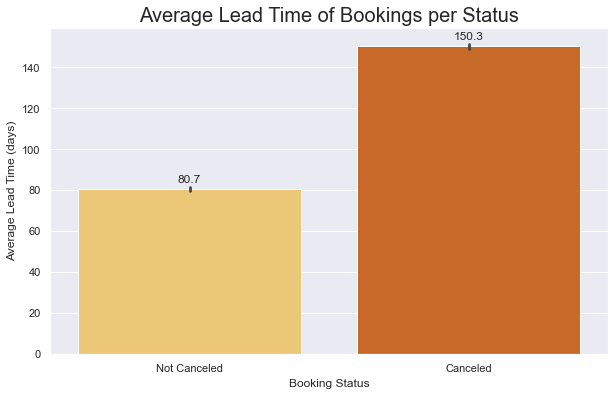

In [91]:
#To visualize the average lead time for canceled and not canceled booking
plt.figure(figsize=(10,6)) 
plt.title("Average Lead Time of Bookings per Status", fontsize = 20)

splot = sns.barplot(x=df['IsCanceled'], y=df['LeadTime'], palette='YlOrBr')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Lead Time (days)", fontsize = 12, labelpad = 5)

plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

As we can see, when we are evaluating the Lead Time, we can see that canceled bookings has a bigger average lead time.


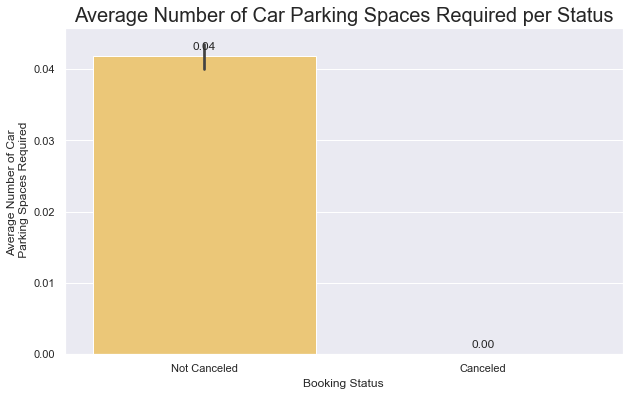

In [92]:
# To visualize the total number of requested parking spaces for canceled and not canceled bookings
plt.figure(figsize=(10,6)) 
plt.title("Average Number of Car Parking Spaces Required per Status", fontsize = 20)

splot = sns.barplot(x=df['IsCanceled'], y=df['RequiredCarParkingSpaces'], palette='YlOrBr')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Car \n Parking Spaces Required", fontsize = 12, labelpad = 5)

plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

As we can see, people that not canceled their bookings require more parking spaces.

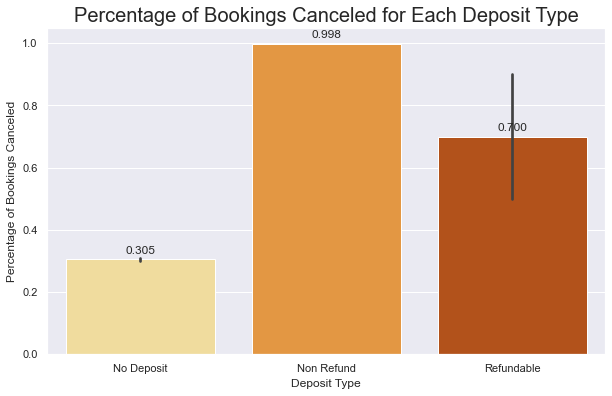

In [93]:
# To visualize ther percentage of bookings canceled for each deposit type
plt.figure(figsize=(10,6)) 
plt.title("Percentage of Bookings Canceled for Each Deposit Type", fontsize = 20)

splot = sns.barplot(x=df['DepositType'], y=df['IsCanceled'], palette='YlOrBr')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.xlabel("Deposit Type", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12, labelpad = 5);

We can see that the clients who pay non-refundable deposit, have a higher percentage of bookings canceled.

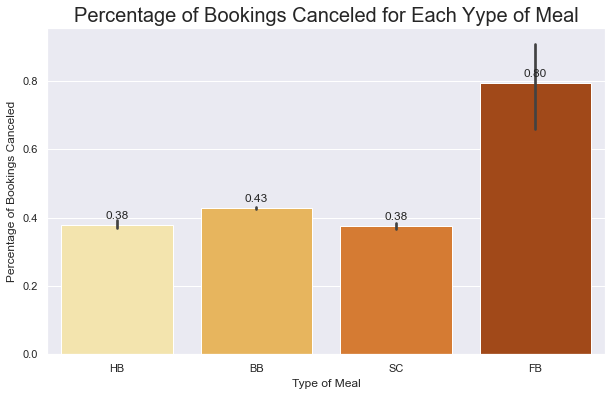

In [94]:
#To Visualize percentage of bookings canceled for each Meal type
plt.figure(figsize=(10,6)) 
plt.title("Percentage of Bookings Canceled for Each Yype of Meal", fontsize = 20)

splot = sns.barplot(x=df['Meal'], y=df['IsCanceled'], palette='YlOrBr')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.xlabel("Type of Meal", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12, labelpad = 5);

We can see that the people with who pay for FB Meal, have a higher percentage of bookings canceled.

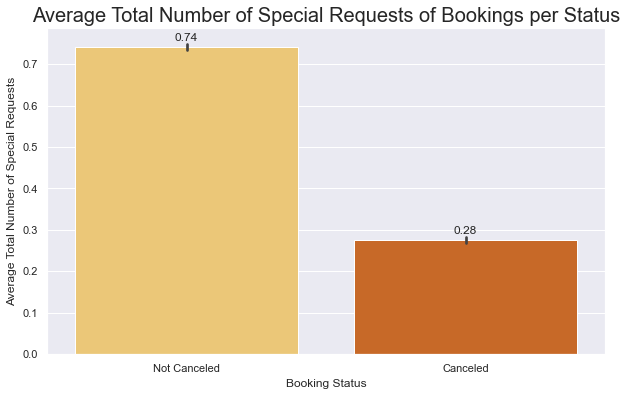

In [95]:
# To visualize the total number of special requests for canceled and not canceled bookings
plt.figure(figsize=(10,6)) 
plt.title("Average Total Number of Special Requests of Bookings per Status", fontsize = 20)

splot = sns.barplot(x=df['IsCanceled'], y=df['TotalOfSpecialRequests'], palette='YlOrBr')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Total Number of Special Requests", fontsize = 12, labelpad = 5)

plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

As we can see, the custoomers that have an higher average of number of special requests don't cancel their bookings.

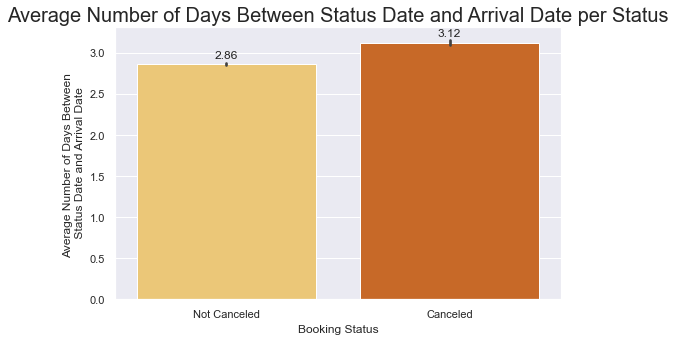

In [96]:
# To visualize average number of days between status date and arrival date for canceled and not canceled bookings
plt.figure(figsize=(8,5))
plt.title("Average Number of Days Between Status Date and Arrival Date per Status", fontsize = 20)

splot = sns.barplot(x=df['IsCanceled'], y=df['StatusToArrivalDate'], palette='YlOrBr')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'),
    (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center',
    xytext = (0, 9),
    textcoords = 'offset points')
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Days Between \n Status Date and Arrival Date", fontsize = 12, labelpad = 5)

plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

In [97]:
# Created a dataframe of canceled bookings for plotting purposes
Canceled = df[df['IsCanceled']==1][['ArrivalDateFull']]
Canceled.set_index('ArrivalDateFull', inplace=True)
Canceled['count'] = 1
Canceled=Canceled.resample('M').sum()

# Created a dataframe of not canceled bookings for plotting purposes
Not_canceled = df[df['IsCanceled']==0][['ArrivalDateFull']]
Not_canceled.set_index('ArrivalDateFull', inplace=True)
Not_canceled['count'] = 1
Not_canceled=Not_canceled.resample('M').sum()

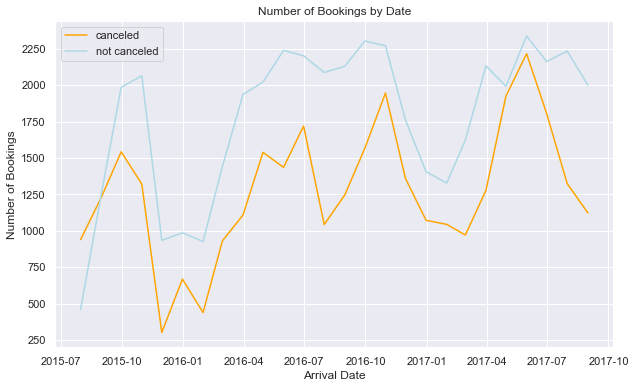

In [98]:
# Visualizing the number of canceled and not canceled bookings by date:
plt.figure(figsize=(10,6))

sns.lineplot(x=Canceled.index, y=Canceled['count'], color='orange')
sns.lineplot(x=Not_canceled.index, y=Not_canceled['count'], color='lightblue')

plt.ylabel('Number of Bookings')
plt.xlabel('Arrival Date')
plt.title('Number of Bookings by Date')
plt.legend(['canceled', 'not canceled']);

As we can see, they have a similar behaviour. We can also notice that people, in January. We can notice also that in July of 2015 the number of canceled bookings was higher than the not canceled.

###  Model Preparation

In [117]:
#To do the one hot enconding on categorical variables
ohc_features = ['ArrivalDateMonth', 'Meal', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'CustomerType']
ohc = OneHotEncoder(sparse=False)

df_ohc = pd.DataFrame(ohc.fit_transform(df[ohc_features]),
                      index=df.index,
                      columns=ohc.get_feature_names(ohc_features))

In [118]:
# Label encode target variable
df['IsCanceled'] = LabelEncoder().fit_transform(df['IsCanceled'])

In [119]:
df_new = pd.concat([df.loc[:, df.columns.drop(ohc_features)], df_ohc], axis=1)

In [120]:
#Here, we remove some variables from our X to our model.
#Firstly, we removed the 'IsCanceled' because is our target.
#Secondly, we removed the 'country', because almost of 50% of the bookings are made by Portuguese people
#We removed, ReservationStatusDate' and 'ArrivalDateFull' because they are dats.
X = df_new.drop(columns=['IsCanceled','ReservationStatus', 'Country', 
                     'ReservationStatusDate', 'ArrivalDateFull'])
y = df_new['IsCanceled']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y, test_size=0.15)

So that we can solve the problem in question, we try to build a model able to predict if the booking will or not be canceled with the highest level of accuracy.
So, we compare the baseline model to the logistic regression, a random forest, a decision tree, a gradient boost classifier and neuronal network.

In [122]:
# We tried to use the Naive Bayes classifier but we decided not included it because it was not very efficient

In [123]:
#Of note who for the realization of the models, we created several joints of parameters and changed them in order to find the best combination.

<div class="alert alert-block alert-info">
    
## <font color='#E8800A'>Baseline</font> <a class="anchor" id="twelveth-bullet"></a>
    
</div>

In [124]:
# Checking baseline model score 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

#Scoring
print("Baseline Training Accuracy: {} ".format(dummy.score(X_train, y_train)))
print("Baseline Testing Accuracy: {} ".format(dummy.score(X_test, y_test)))

Baseline Training Accuracy: 0.5827635813546502 
Baseline Testing Accuracy: 0.5827380452138835 


<div class="alert alert-block alert-info">
    
## <font color='#E8800A'>Logistic Regression</font> <a class="anchor" id="twelveth-bullet"></a>
    
</div>

In [125]:
# Construct Grid Parameters
lg_params = {
    'penalty': ['l1'], 
    'C': [3.5],
    'max_iter': [300]
}

# Perform Grid Search
lg_gs = GridSearchCV(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
                 lg_params,
                 cv = 5,
                 scoring = 'accuracy')

lg = lg_gs.fit(X_train, y_train)

In [126]:
y_train_pred = lg.predict(X_train)
y_test_pred = lg.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     39294
           1       0.85      0.66      0.74     28133

    accuracy                           0.81     67427
   macro avg       0.82      0.79      0.80     67427
weighted avg       0.81      0.81      0.80     67427

[[36022  3272]
 [ 9596 18537]]
___________________________________________________________________________________________________________
                                                    TESTING                                                
------------------------------------------------------------------------------------------------------

In [127]:
# Scoring 
print("Best Training Accuracy: {} ".format(lg.score(X_train, y_train)))
print("Best Testing Accuracy: {} ".format(lg.score(X_test, y_test)))

Best Training Accuracy: 0.8091565693268276 
Best Testing Accuracy: 0.8081351374065048 


This model has a testing acurracy of 80.81%. So, as we can see, this model does not predicte with the accuracy that we would obtain. So, we tried more models.

<div class="alert alert-block alert-info">
    
## <font color='#E8800A'>Random Forest</font> <a class="anchor" id="twelveth-bullet"></a>
    
</div>

In [128]:
# Construct Grid Parameters
rf_params = {
    'n_estimators': [150],  
    'max_features': [50],
    'max_depth': [13]
}

# Perform Grid Search
rf_gs = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                 rf_params,
                 cv = 5,
                 scoring = 'accuracy')

rf = rf_gs.fit(X_train, y_train)

In [129]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     39294
           1       0.97      0.88      0.92     28133

    accuracy                           0.94     67427
   macro avg       0.95      0.93      0.94     67427
weighted avg       0.94      0.94      0.94     67427

[[38555   739]
 [ 3322 24811]]
___________________________________________________________________________________________________________
                                                    TESTING                                                
------------------------------------------------------------------------------------------------------

In [130]:
#Scoring
print("Best Training Accuracy: {} ".format(rf.score(X_train, y_train)))
print("Best Testing Accuracy: {} ".format(rf.score(X_test, y_test)))

Best Training Accuracy: 0.9397719014638053 
Best Testing Accuracy: 0.9342801916127406 


This model has a testing acurracy of 93.6% and it is close to the train score that is 94.0%. This means tha we reduced the variance. As we can see, this model provides a high accuracy. Looking to yhe high testing score, we can understand  that this model provides high prediction. We can see that this model is not overfitted since the training and the testing score are very similar.

<div class="alert alert-block alert-info">
    
## <font color='#E8800A'>Decision Trees</font> <a class="anchor" id="twelveth-bullet"></a>
    
</div>

In [131]:
# Construct Grid Parameters
dt_params = {
    'max_depth':[None],
    'max_features' : [0.7],
    'min_samples_split': [25], 
    'min_samples_leaf': [1]
}

# Perform Grid Search
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                 dt_params,
                 cv = 5,
                 scoring = 'accuracy')

dt = dt_gs.fit(X_train, y_train)

In [132]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     39294
           1       0.98      0.94      0.96     28133

    accuracy                           0.96     67427
   macro avg       0.97      0.96      0.96     67427
weighted avg       0.96      0.96      0.96     67427

[[38679   615]
 [ 1826 26307]]
___________________________________________________________________________________________________________
                                                    TESTING                                                
------------------------------------------------------------------------------------------------------

In [133]:
#Scoring
print("Best Training Accuracy: {} ".format(dt.score(X_train, y_train)))
print("Best Testing Accuracy: {} ".format(dt.score(X_test, y_test)))

Best Training Accuracy: 0.963797885120204 
Best Testing Accuracy: 0.9469703336414825 


In [134]:
#To see the more important features, using the Decision Tree Classifier and using 2 different criterion('entropy' and 'gini')
gini_importance = DecisionTreeClassifier(random_state=RANDOM_STATE).fit(X_train, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(random_state=RANDOM_STATE,criterion='entropy').fit(X_train, y_train).feature_importances_

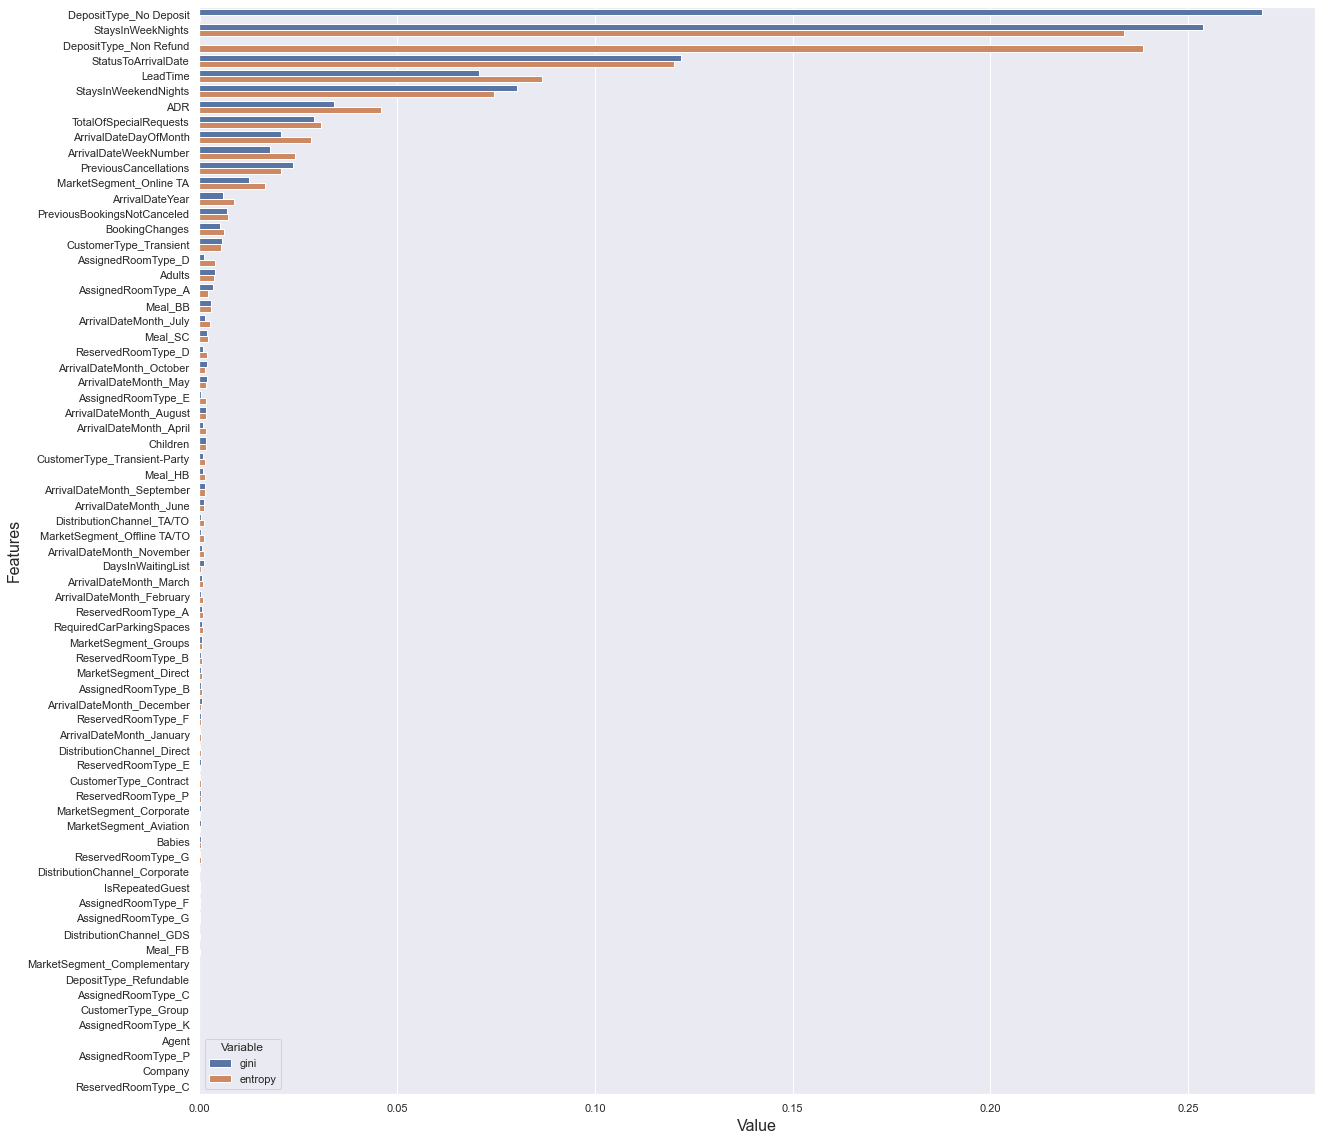

In [135]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_train.columns

tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(20,20))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy);

plt.xlabel("Value",fontsize = 16, labelpad = 5)
plt.ylabel("Features", fontsize = 16, labelpad = 5);

We tried to remove some variables that they are not so important and we apply again this model (Desion Tree).

In [136]:
X_copy = X.copy()

In [137]:
X_dt = X_copy.drop(['DepositType_Refundable','ReservedRoomType_C', 'Meal_FB', 'AssignedRoomType_K','CustomerType_Group','AssignedRoomType_C','MarketSegment_Complementary','DistributionChannel_GDS','AssignedRoomType_G','IsRepeatedGuest','DistributionChannel_Corporate','MarketSegment_Aviation'],axis=1)

In [138]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_dt, y, random_state=RANDOM_STATE, stratify=y, test_size=0.15)

In [139]:
# Construct Grid Parameters
dt_params = {
    'criterion' : ['entropy'],
    'max_depth':[None],
    'max_features' : [0.7],
    'min_samples_split': [25], 
    'min_samples_leaf': [1],
}

# Perform Grid Search
dt_gs_0 = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                 dt_params,
                 cv = 5,
                 scoring = 'accuracy')

dt_0 = dt_gs.fit(X_train_0, y_train_0)

In [140]:
y_train_pred_0 = dt_0.predict(X_train_0)
y_test_pred_0 = dt_0.predict(X_test_0)
metrics(y_train_0,y_train_pred_0,y_test_0,y_test_pred_0)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     39294
           1       0.98      0.94      0.96     28133

    accuracy                           0.97     67427
   macro avg       0.97      0.96      0.97     67427
weighted avg       0.97      0.97      0.97     67427

[[38749   545]
 [ 1669 26464]]
___________________________________________________________________________________________________________
                                                    TESTING                                                
------------------------------------------------------------------------------------------------------

In [141]:
#Scoring
print("Best Training Accuracy: {} ".format(dt_0.score(X_train_0, y_train_0)))
print("Best Testing Accuracy: {} ".format(dt_0.score(X_test_0, y_test_0)))

Best Training Accuracy: 0.9671644890029216 
Best Testing Accuracy: 0.9479788217497269 


As we can see, removing some features did not improve our model and, this way, we are only comparing the last one. 
We have a test accuracy of 95.0%.
This model is slightly overfit with a training score of 96.6% higher than our 95.0% accuracy testing score.
The cross validation score is very close to the testing one. We can also notice that the last one has a higher score and it indicates that this model have a higher prediction.
We can notice that both Decision Trees models are overfitted because the training score e higher that the testing one.
However, without removing the features, our model presents is more overfitted.

<div class="alert alert-block alert-info">
    
## <font color='#E8800A'>Gradient Boost Classifier</font> <a class="anchor" id="twelveth-bullet"></a>
    
</div>

In [186]:
gb = GradientBoostingClassifier(n_estimators=100,max_features=15,random_state=100,max_depth=16,min_samples_leaf=8) 
gb.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=16, max_features=15, min_samples_leaf=8,
                           random_state=100)

In [187]:
best_scale(gb,X_train,y_train,X_test,y_test)

,F1 Score
Standard,0.964703
MinMax,0.762417
MaxAbs,0.762417
Robust,0.964871
No Scaler,0.964955


We see the variables that they are not so important and we apply the model

In [188]:
importances = gb.feature_importances_
indices = np.argsort(importances)

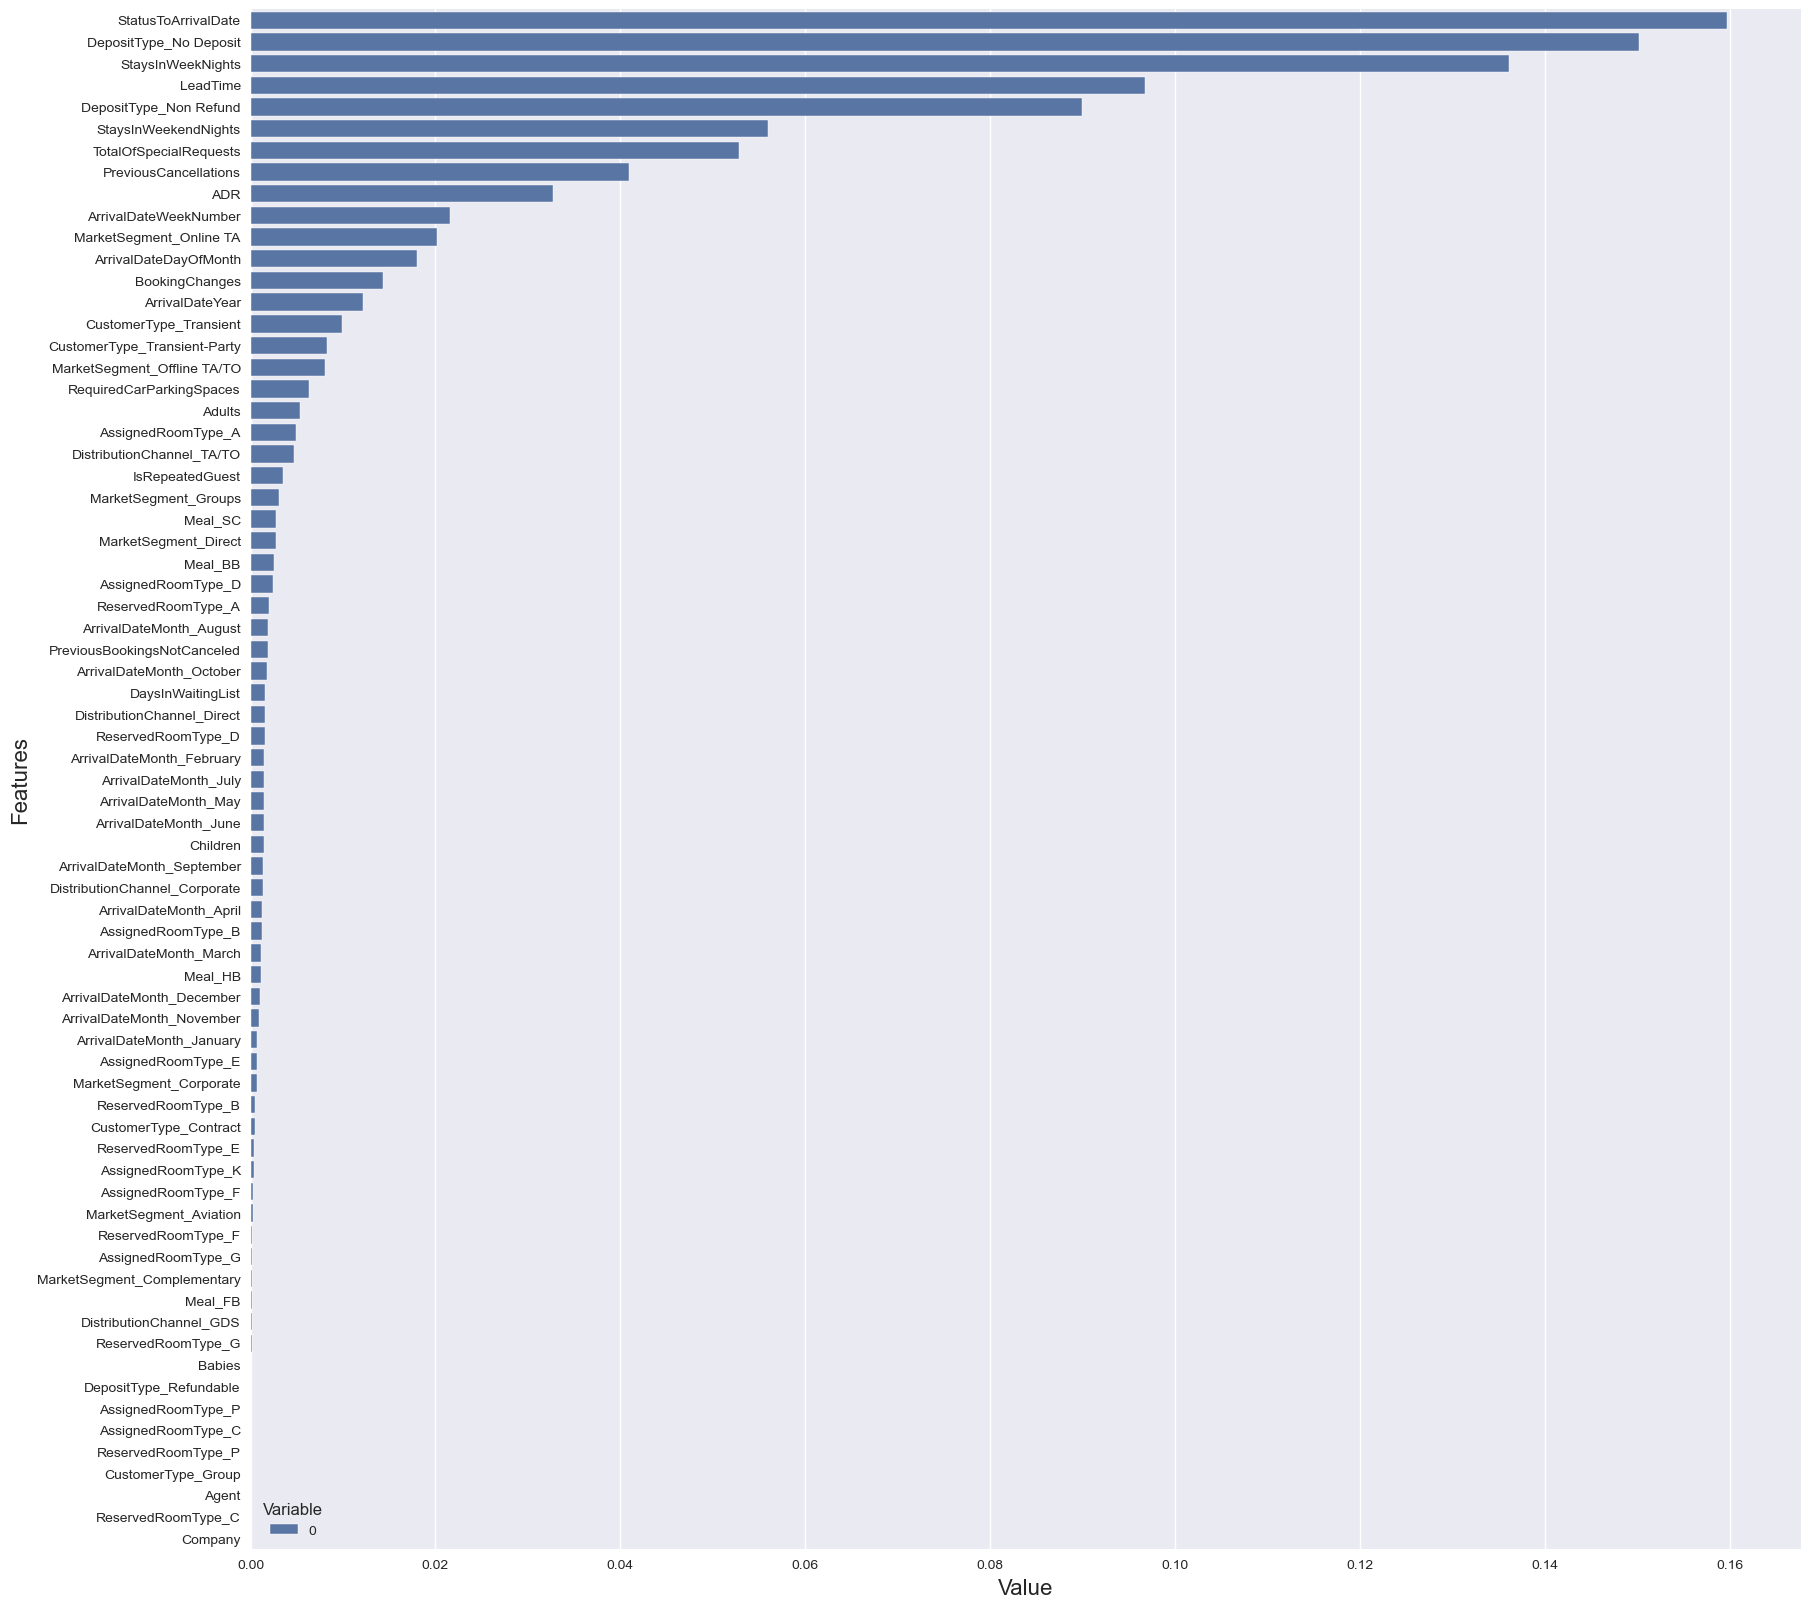

In [189]:
zippy = pd.DataFrame(zip(importances))
zippy['col'] = X_train.columns

tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(20,20))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy);

plt.xlabel("Value",fontsize = 16, labelpad = 5)
plt.ylabel("Features", fontsize = 16, labelpad = 5);

Now, we're going to apply our model

In [190]:
X_copy = X.copy()

In [191]:
X_gb = X_copy.drop(["DepositType_Refundable","ReservedRoomType_P","ReservedRoomType_G","ReservedRoomType_C","AssignedRoomType_P","AssignedRoomType_C","Babies","DistributionChannel_GDS","AssignedRoomType_K"],axis=1)

In [192]:
gb_columns = X_gb.columns

In [193]:
#To standardize the features
scaler = StandardScaler().fit(X_gb)
scaler_X = scaler.transform(X_gb)

In [194]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(scaler_X, y, train_size=0.8, random_state=42,stratify=y,shuffle=True)

###### GB without Grid Search

In [195]:
gb_0 = GradientBoostingClassifier(n_estimators=100,max_features=17,random_state=70,max_depth=5,min_samples_leaf=9) 
gb_0.fit(X_train_1,y_train_1)

GradientBoostingClassifier(max_depth=5, max_features=17, min_samples_leaf=9,
                           random_state=70)

In [196]:
y_train_pred_1 = gb_0.predict(X_train_1)
y_test_pred_1 = gb_0.predict(X_test_1)
metrics(y_train_1,y_train_pred_1,y_test_1,y_test_pred_1)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     36982
           1       0.97      0.85      0.90     26478

    accuracy                           0.93     63460
   macro avg       0.94      0.91      0.92     63460
weighted avg       0.93      0.93      0.92     63460

[[36321   661]
 [ 4071 22407]]
___________________________________________________________________________________________________________
                                                    TESTING                                                
------------------------------------------------------------------------------------------------------

In [201]:
gb_f1_test = micro_f1_score(y_train_1,y_train_pred_1,y_test_1,y_test_pred_1)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
0.9254333438386385
_____________________________________
                                                    TESTING                                                
-----------------------------------------------------------------------------------------------------------
0.9248077650321442


In [202]:
#Scoring
print("Best Training Accuracy: {} ".format(gb_0.score(X_train_1, y_train_1)))
print("Best Testing Accuracy: {} ".format(gb_0.score(X_test_1, y_test_1)))

Best Training Accuracy: 0.9254333438386385 
Best Testing Accuracy: 0.9248077650321442 


###### GB with Grid Search

In [203]:
# Construct Grid Parameters
gb_params = {
    'n_estimators': [150],  
    'max_features': [50],
    'max_depth': [13],
    'min_samples_leaf': [10]
}

# Perform Grid Search
gb_gs = GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE),
                 gb_params,
                 cv = 5,
                 scoring = 'accuracy')

gb_1 = gb_gs.fit(X_train_1, y_train_1)

In [204]:
y_train_pred_1 = gb_1.predict(X_train_1)
y_test_pred_1 = gb_1.predict(X_test_1)
metrics(y_train_1,y_train_pred_1,y_test_1,y_test_pred_1)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36982
           1       1.00      1.00      1.00     26478

    accuracy                           1.00     63460
   macro avg       1.00      1.00      1.00     63460
weighted avg       1.00      1.00      1.00     63460

[[36977     5]
 [   89 26389]]
___________________________________________________________________________________________________________
                                                    TESTING                                                
------------------------------------------------------------------------------------------------------

In [205]:
gb_f1_test= micro_f1_score(y_train_1,y_train_pred_1,y_test_1,y_test_pred_1)

_____________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
0.9985187519697447
_____________________________________
                                                    TESTING                                                
-----------------------------------------------------------------------------------------------------------
0.9735913273666961


In [206]:
print("Best Training Accuracy: {} ".format(gb_1.score(X_train_1, y_train_1)))
print("Best Testing Accuracy: {} ".format(gb_1.score(X_test_1, y_test_1)))

Best Training Accuracy: 0.9985187519697447 
Best Testing Accuracy: 0.9735913273666961 


As we can see, using the Grid Search with Gradient Boost will improve our model and, this way, we are comparing the last one.
We have a testing accuracy of 97.32%.
We can also notice that the testing score has a higher score and it indicates that this model have a higher prediction.
We can see that this model is overfitted because the training score is higher than the accuracy testing score.


<div class="alert alert-block alert-info">
    
## <font color='#E8800A'>Neuronal Networks</font> <a class="anchor" id="twelveth-bullet"></a>
    
</div>

In [159]:
X.shape

(79326, 71)

In [160]:
# Scaling the data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# define the keras model
model = Sequential()

model.add(Dense(64, input_dim = 71,activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', patience=5) 

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the keras model on the dataset
history = model.fit(X_train_sc, y_train, batch_size = 256, validation_data =(X_test_sc, y_test),epochs=300, verbose = 0,callbacks=[es])

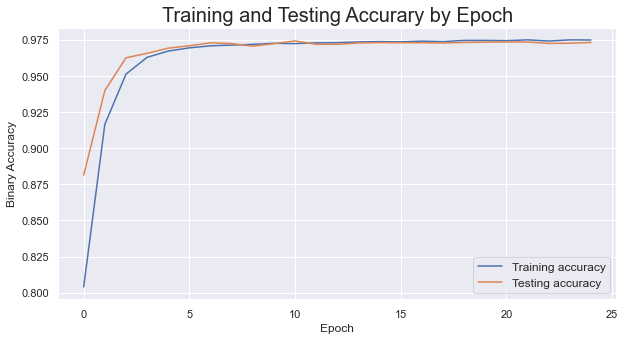

In [161]:
# To visualize our training and testing accuracy by epoch
plt.figure(figsize=(10, 5))

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Testing accuracy')

plt.title('Training and Testing Accurary by Epoch', fontsize = 20)

plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)

plt.legend(fontsize = 12);

In [162]:
# Scoring
train_score = model.evaluate(X_train_sc, y_train, verbose=1)
test_score = model.evaluate(X_test_sc, y_test,verbose=1)

labels = model.metrics_names

print("Training Accuracy: {} ".format(train_score[1]))
print("Testing Accuracy: {} ".format(test_score[1]))

372/372 [==============================] - 0s 534us/step - loss: 0.0897 - accuracy: 0.9731
Training Accuracy: 0.9757070541381836 
Testing Accuracy: 0.9731069803237915 


Our model has a training accuracy of 97.4% and is very close to our 97.2% accuracy testing. This means that our model is not overfitting.The high testing score indicates that this model provides high prediction.
For that reason(not be overfitted), we decided that Neural Network is the best model to predict.

## SELECTION

In [166]:
predictive_model_scores = pd.DataFrame(data=[('Baseline',0.582763, 0.582738), ('Logistic Regression',0.809156, 0.808135), ('Random Forest',0.939771, 0.934280), 
                                             ('Decision Tree',0.967164, 0.947978), ('Neural Network',0.975707, 0.973106),('Gradient Boost Classification',0.998518, 0.973591)
                                             ],
                                       columns=['model', 'training_accuracy', 'testing_accuracy'])

In [167]:
predictive_model_scores

,model,training_accuracy,testing_accuracy
0,Baseline,0.582763,0.582738
1,Logistic Regression,0.809156,0.808135
2,Random Forest,0.939771,0.934280
3,Decision Tree,0.967164,0.947978
4,Neural Network,0.975707,0.973106
5,Gradient Boost Classification,0.998518,0.973591


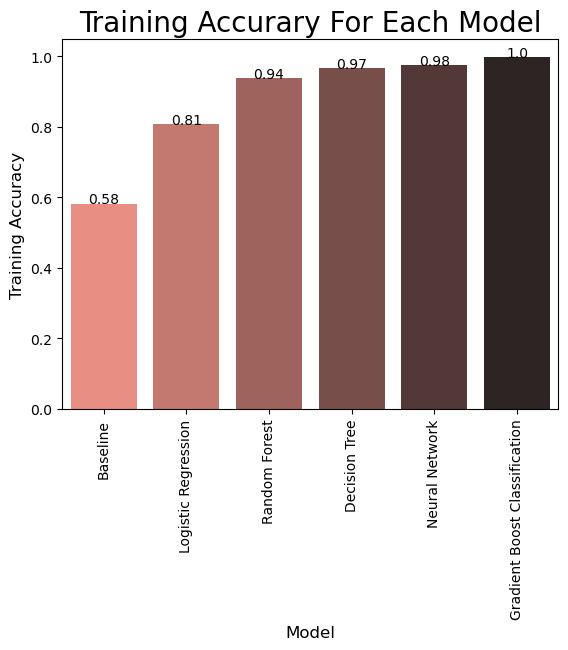

In [168]:
# To visualize Training accuracy of each model
plt.style.use('default')
plt.figure()

p=sns.barplot(x='model', y='training_accuracy', data=predictive_model_scores, palette='dark:salmon_r')

plt.title('Training Accurary For Each Model', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('Training Accuracy', fontsize = 12)

plt.xticks(rotation = 90)


for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.training_accuracy, s=round(row.training_accuracy,2), color='black', horizontalalignment='center');


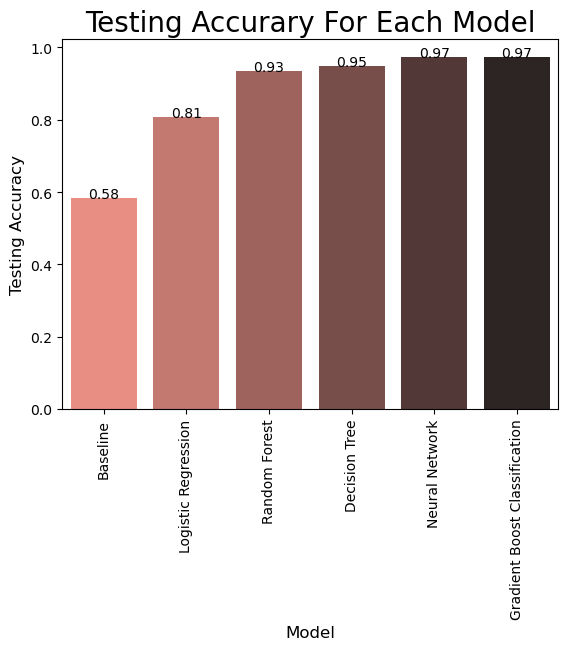

In [169]:
# To visualize testing accuracy of each model
plt.style.use('default')
plt.figure()


p=sns.barplot(x='model', y='testing_accuracy', data=predictive_model_scores, palette='dark:salmon_r')

plt.title('Testing Accurary For Each Model', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('Testing Accuracy', fontsize = 12)

plt.xticks(rotation = 90)


for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.testing_accuracy, s=round(row.testing_accuracy,2), color='black', horizontalalignment='center');




# CONFUSION MATRIX


In [170]:
# Making predictions
nn_predictions = model.predict_classes(X_test_sc)

# Creating confusion matrix 
cm = confusion_matrix(y_test, nn_predictions)

# putting the matrix a dataframe form  
cm_df = pd.DataFrame(cm, index=['Actually Not Canceled', 'Actually Canceled'],
                 columns=['Predicted Not Canceled', 'Predicted Canceled'])


Text(0.5, 1.0, 'Confusion Matrix')

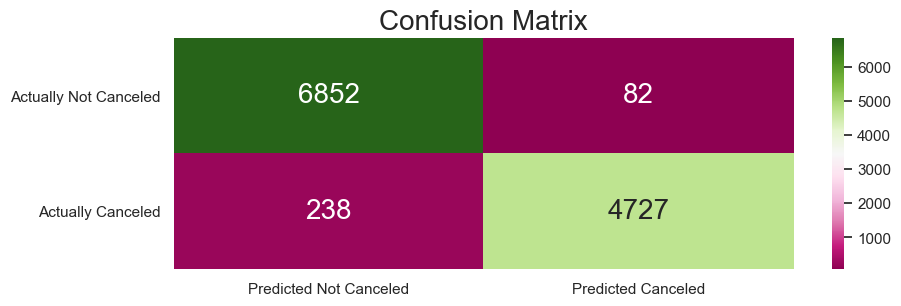

In [171]:
# To visualize the confusion matrix
sns.set(font_scale=1)
plt.figure(figsize=(10,3))
    
sns.heatmap(cm, annot=True, fmt='g', cmap="PiYG",xticklabels=cm_df.columns, yticklabels=cm_df.index, annot_kws={"size": 20})

plt.title("Confusion Matrix", size=20)

In [173]:
# True Positives:
TP = 4727
# True Negatives:
TN = 6852
# False Posititives: 
FP = 82
# False Negatives: 
FN = 238

total = TP+TN+FP+FN

#Accuracy
print('\033[1mAccuracy: How often is the classifier correct?:\033[0m {}%'.format(np.round((TP+TN)/total*100)))
#Error Rate
print('\033[1mMisclassification Rate: How often is classifier wrong?:\033[0m {}%\n'.format(np.round((FP+FN)/total*100))) 

#Recall-->True Positive Rate
print('\033[1mCanceled bookings correctly classified\033[0m: {}%'.format(np.round(TP/(TP+FN)*100)))
#True Negative Rate
print('\033[1mNot Canceled bookings correctly classified:\033[0m: {}%'.format(np.round(TN/(TN+FP)*100)))
#False Positive Rate:
print('\033[1mNot Canceled bookings not correctly classified:\033[0m: {}%\n'.format(np.round(FP/(TN+FP)*100)))

#Precision
print('\033[1mBookings predicted canceled that are actually canceled:\033[0m: {}%'.format(np.round(TP/(TP+FP)*100)))
print('\033[1mBookings predicted not canceled that are actually not canceled:\033[0m: {}%\n'.format(np.round(TN/(TN+FN)*100)))

print('\033[1mPrevalence: How often does the yes condition(canceled booking) actually occur in our sample?\033[0m: {}%'.format(np.round((TP+FN)/(total)*100)))


Accuracy: How often is the classifier correct?: 97.0%
Misclassification Rate: How often is classifier wrong?: 3.0%

Canceled bookings correctly classified: 95.0%
Not Canceled bookings correctly classified:: 99.0%
Not Canceled bookings not correctly classified:: 1.0%

Bookings predicted canceled that are actually canceled:: 98.0%
Bookings predicted not canceled that are actually not canceled:: 97.0%

Prevalence: How often does the yes condition(canceled booking) actually occur in our sample?: 42.0%


We classify correctly 97% of the bookings. As we can see, we are correcly predicting 95% of the canceled bookings and 99% of the not canceled bookings.
Actually, looking for our confusion matrix, we can see that 262 bookings that our model predicted to be not canceled and that were actually canceled. 
We can see also that, our model predicts 63 bookings that were canceled and they are not canceled.

## Variable importance after prediction

In [207]:
clf = gb

In [208]:
tr_x = X_train

In [209]:
tr_x.shape

(67427, 71)

In [210]:
# Creating a dataframe of features and their associated feature important scores using the gradient boost
coefficients = pd.DataFrame(clf.feature_importances_, tr_x.columns)
coefficients.rename(columns = {0: 'coef'}, inplace=True)

In [211]:
# Filtering the 8 important features 
top_coef = coefficients.copy()
top_coef = top_coef.sort_values(by='coef', ascending = False)[0:8]
top_coef

,coef
StatusToArrivalDate,0.159690
DepositType_No Deposit,0.150227
StaysInWeekNights,0.136189
LeadTime,0.096708
DepositType_Non Refund,0.089953
StaysInWeekendNights,0.055994
TotalOfSpecialRequests,0.052802
PreviousCancellations,0.040899


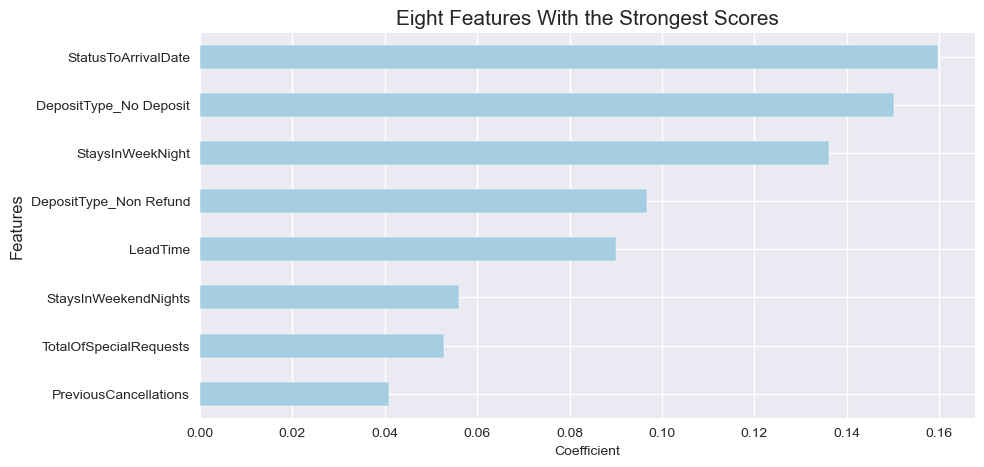

In [213]:
# Visualizing the 10 strongest coefficients 
plt.figure(figsize=(10,5), facecolor = 'w')
plt.style.use('seaborn')

top_coef.sort_values(by='coef')['coef'].plot(kind='barh', legend=None, cmap='Paired')

plt.title('Eight Features With the Strongest Scores', size=15)
plt.ylabel('Features', size=12)
plt.xlabel('Coefficient', size=10)

plt.yticks(np.arange(8),['PreviousCancellations', 'TotalOfSpecialRequests', 'StaysInWeekendNights', 
                           'LeadTime', 'DepositType_Non Refund', 'StaysInWeekNight', 
                           'DepositType_No Deposit', 'StatusToArrivalDate',]);


As we can see, this plot show us the 8 most important variables. The 3 most important are: 'StatusToArrivalDate', 'DepositType_No Deposit' and 'StayInWeekNight'. These are the 3 variables that have more influence in predicting if or not a booking will be canceled.